# Implementing Boundary Conditions: From Linear to Nonlinear in FEM

In [4]:
using Ferrite, SparseArrays, Plots, LinearAlgebra

In [5]:
# deliberately use include to include code 
# see e.g. https://docs.julialang.org/en/v1/manual/code-loading/ 
include("flemish-fish.jl")

In [6]:
?fdmmesh

search: fdmmesh



Generates a one-dimensional uniform mesh between point 0 and 1

Input N(1) is number of elements. Output is the one-dimensional mesh. 

[`mesh(::NTuple{1,Int})`](@ref)

---

Generates a two-dimensional mesh between the points (0,0) and (1,1) 

Input N(1) and N(2) are the number of elements in x and y direction. Output is the two-dimensional mesh. 

[`mesh(::NTuple{2,Int})`](@ref)

---

Generates a two-dimensional mesh between the points a and b 

Input N(1) and N(2) are the number of elements in x and y direction. Output is the two-dimensional mesh. 

[`mesh(::NTuple{2,Int},::Point2D,::Point2D)`](@ref)


## Introduction 

This notebook outlines a structured approach to understanding and implementing boundary conditions (BCs) in numerical simulations. O

1.  **Hand-Coding Linear Dirichlet Boundary Conditions:** We will start by examining how existing libraries typically apply linear Dirichlet BCs, where a specific degree of freedom $\mathbf{u}_i$ is set to a fixed value $C$ (i.e., $\mathbf{u}_i = C$). Our focus will be on understanding how this condition translates into direct modifications of the global stiffness matrix $\mathbf{K}$ and the right-hand side vector $\mathbf{f}$. We will then proceed to "hand-code" this modification ourselves, learning how specific rows and columns of these matrices are altered to impose the constraint.

2.  **Implementing Affine Constraints:** Building upon the understanding of linear Dirichlet conditions, we will extend our capabilities to more general **affine constraints**. These are linear relationships involving multiple degrees of freedom, expressed as $\sum_{j} a_j \mathbf{u}_j = C$. A common example is enforcing a mean value constraint on a field variable over a certain region. This step will further develop our intuition for how linear dependencies are embedded within the algebraic system.

3.  **Extending to Nonlinear Boundary Conditions via Newton's Method:** Finally, we will apply the insights gained from handling linear constraints to the realm of nonlinear boundary conditions. For a nonlinear problem, the governing equations, including boundary conditions, form a system of nonlinear algebraic equations, $\mathbf{F}(\mathbf{u}) = \mathbf{0}$. We will solve this system using the Newton-Raphson method, which relies on solving a linearized system at each iteration: $J(\mathbf{u}^k) \mathbf{\delta u} = -\mathbf{F}(\mathbf{u}^k)$. Here, $J(\mathbf{u}^k)$ is the Jacobian matrix. Our key focus will be on how the nonlinear boundary condition (e.g., $[\rho_g(0)]^2 = 2$ from our previous work) is integrated into the residual function $\mathbf{F}(\mathbf{u})$ and, crucially, how its linearization appears within the Jacobian $J(\mathbf{u})$. This consolidates the understanding that even a nonlinear boundary condition translates to a linear contribution to the Jacobian system solved at each Newton iteration.

## Section 1 : Hand-Coded Linear Dirichlet Boundary Condition 

In this section, we will revisit our existing code from **section 4.1** of the "HydrogenProject" notebook : https://github.com/AnouchkaDESMETTRE/HydrogenProject/blob/main/HydrogenProject.ipynb, which addresses the steady-state gas density absorption equation:

$$D \frac{d^2 \rho_g}{dz^2} + u_z \frac{d \rho_g}{dz} + \dot{m} = 0$$

Our primary focus here will be to deeply understand how linear Dirichlet boundary conditions are implemented using Ferrite's `apply!(K,f,ch)` for FEM). Specifically, we will investigate how the system matrix $K$ and the right-hand side vector $f$ are directly modified. The goal is to explicitly "hand-code" the implementation of this Dirichlet boundary condition. This means we will bypass the high-level `applybc!` function for the Dirichlet constraint and instead directly manipulate the relevant row(s) of the discretized matrix and vector to enforce the condition $\rho_g(z_{boundary}) = C$. This exercise will provide a granular understanding of the algebraic changes required to impose such constraints.

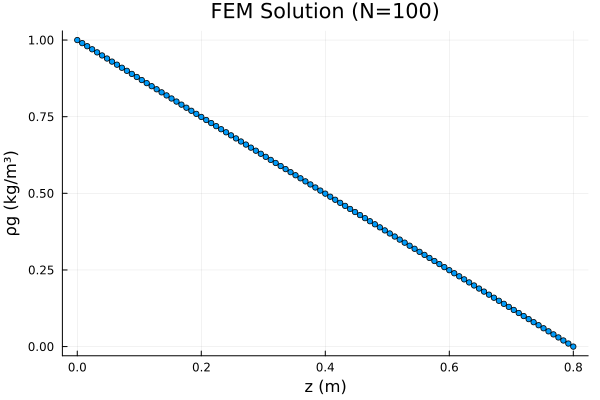

In [7]:
# Problem parameters
L = 0.8
D = 1.0
uz = 0.01
m_dot = 0.0
N = 100 # Directement défini comme un entier

interpolation = Lagrange{RefLine, 1}()
qr = QuadratureRule{RefLine}(2)
cell_values = CellValues(qr, interpolation)

# Définition précise du domaine
left = Vec((0.,))
right = Vec((L,))
grid = generate_grid(Ferrite.Line, (N,), left, right)

dh = DofHandler(grid)
add!(dh, :rho_g, interpolation)
close!(dh)

K = allocate_matrix(dh)
f = zeros(ndofs(dh))

function assemble!(K, f, cv, dh, D, uz, m_dot)
    assembler = start_assemble(K, f)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cv, cell)
        n_basefuncs = getnbasefunctions(cv)
        Ke = zeros(n_basefuncs, n_basefuncs)
        fe = zeros(n_basefuncs)
        for q in 1:getnquadpoints(cv)
            dΩ = getdetJdV(cv, q)
            for i in 1:n_basefuncs
                ϕ = shape_value(cv, q, i)
                ∇ϕ = shape_gradient(cv, q, i)[1]
                for j in 1:n_basefuncs
                    ∇ϕ_j = shape_gradient(cv, q, j)[1]
                    Ke[i, j] += (D * ∇ϕ * ∇ϕ_j - uz * ϕ * ∇ϕ_j) * dΩ
                end
                fe[i] += m_dot * ϕ * dΩ
            end
        end
        Ferrite.assemble!(assembler, celldofs(cell), Ke, fe)
    end
end

assemble!(K, f, cell_values, dh, D, uz, m_dot)

ch = ConstraintHandler(dh)
dbc1 = Dirichlet(:rho_g, [1], (x, t) -> 1.0) # Appliquer au nœud 1
dbc2 = Dirichlet(:rho_g, [Ferrite.getnnodes(grid)], (x, t) -> 0.0) # Appliquer au dernier nœud
add!(ch, dbc1)
add!(ch, dbc2)
close!(ch)

apply!(K, f, ch)

rho_g = K \ f

rho_g_computed_at_nodes = evaluate_at_grid_nodes(dh, rho_g, :rho_g)

# Génération des coordonnées z à partir des nœuds du maillage
z_coords = [grid.nodes[node].x[1] for node in 1:length(grid.nodes)]

# Initialiser le plot
p_solution = plot(title="FEM Solution (N=$N)",
    xlabel="z (m)", ylabel="ρg (kg/m³)", lw=2, legend=false) # legend=false car une seule courbe

# Plot de la solution FEM
plot!(p_solution, z_coords, rho_g_computed_at_nodes, label="FEM Solution", lw=2, markershape=:circle, markersize=3)

# Afficher le plot
display(p_solution)

# Section 2: Affine Constraints as Boundary Conditions 

# Section 3: Extension to the Non-Linear Case 